1. Importing Libraries

In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import re
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

2. Data Preprocessing

In [ ]:
# Loading dataset
df = pd.read_csv('DataNeuron_Text_Similarity.csv')  # replace with your actual file path or upload to Colab

# Text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)              # Remove URLs
    text = re.sub(r"[^a-z0-9\s]", "", text)          # Remove punctuation and special chars
    text = re.sub(r"\s+", " ", text).strip()         # Remove extra spaces
    return text

# Apply cleaning
df['text1'] = df['text1'].apply(clean_text)
df['text2'] = df['text2'].apply(clean_text)

# Drop any rows where cleaning caused empty strings
df = df[(df['text1'] != '') & (df['text2'] != '')].reset_index(drop=True)

print(f"Data loaded and cleaned. Number of valid rows: {len(df)}")


Data loaded and cleaned. Number of valid rows: 3000


3. Exploratory Data Analysis

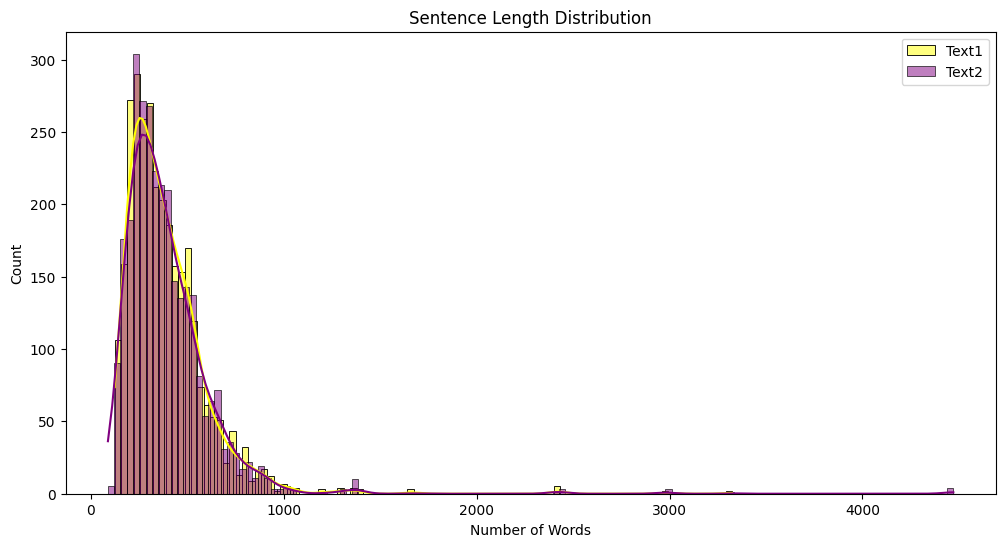

In [ ]:
# This shows how long the sentences are in both columns. Very long or very short ones may influence similarity.
# Calculate lengths
df['len_text1'] = df['text1'].apply(lambda x: len(x.split()))
df['len_text2'] = df['text2'].apply(lambda x: len(x.split()))

# Plot
plt.figure(figsize=(12,6))
sns.histplot(df['len_text1'], color='yellow', label='Text1', kde=True)
sns.histplot(df['len_text2'], color='purple', label='Text2', kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

The above histogram depicts sentence length distribution, since this is left skewed we can sonclude that most of the sentences are short.

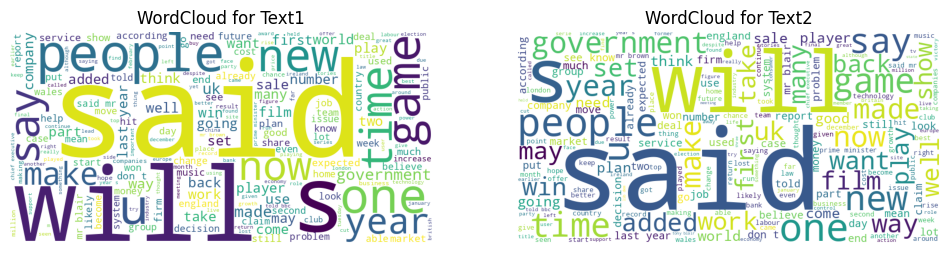

In [ ]:
# Combine all text
text1_words = ' '.join(df['text1'].tolist())
text2_words = ' '.join(df['text2'].tolist())

# WordClouds
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(text1_words))
plt.title("WordCloud for Text1")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(text2_words))
plt.title("WordCloud for Text2")
plt.axis('off')

plt.show()


The above word cloud depicts most frequent words in text1 and text2, we can see that there are frequently appearing words that are also common which shows us that there is a similarity between the 2 texts.

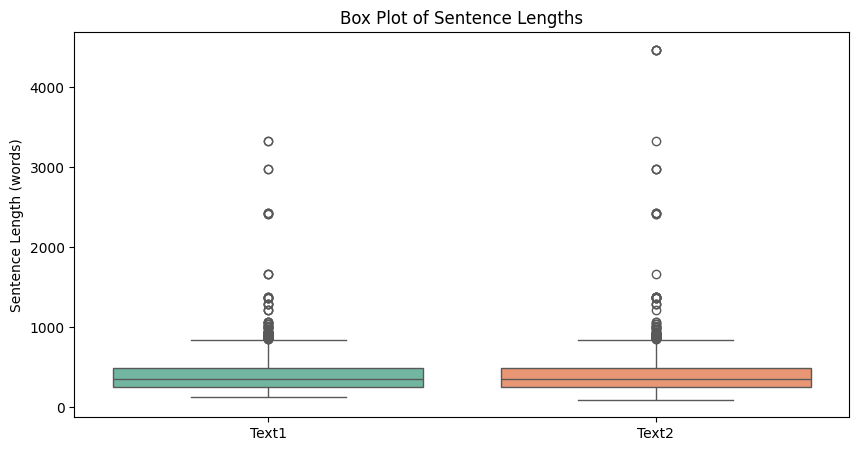

In [ ]:
#Useful for checking outliers and length distribution.

plt.figure(figsize=(10,5))
sns.boxplot(data=[df['len_text1'], df['len_text2']], palette='Set2')
plt.xticks([0, 1], ['Text1', 'Text2'])
plt.ylabel("Sentence Length (words)")
plt.title("Box Plot of Sentence Lengths")
plt.show()


The above box plot helps us to understand the spread and center of sentence lengths, makes it easy to spot extreme values or anomalies. Since we have a very short box, we can interpret that the lengths are similar (low variance). And the dots lying far away are outliers.

4. Split the dataset

In [ ]:
# Split the dataset - 80% train, 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Training samples:", len(train_df))
print("Testing samples:", len(test_df))

Training samples: 2400
Testing samples: 600


5. Load Embedding Models

In [ ]:
# Load SBERT model
print("Loading SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load Universal Sentence Encoder (USE) from TF Hub
print("Loading Universal Sentence Encoder...")
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


Loading SBERT model...
Loading Universal Sentence Encoder...


6. Generate SBERT embeddings

In [ ]:
print("Encoding text1 with SBERT...")
embeddings_text1_sbert = sbert_model.encode(train_df['text1'].tolist(), convert_to_tensor=False)

print("Encoding text2 with SBERT...")
embeddings_text2_sbert = sbert_model.encode(train_df['text2'].tolist(), convert_to_tensor=False)


Encoding text1 with SBERT...
Encoding text2 with SBERT...


7. Generate USE embeddings

In [ ]:
print("Encoding text1 with USE...")
embeddings_text1_use = use_model(train_df['text1'].tolist())

print("Encoding text2 with USE...")
embeddings_text2_use = use_model(train_df['text2'].tolist())


Encoding text1 with USE...
Encoding text2 with USE...


8. Compute TF-IDF cosine similarity

In [ ]:
print("Computing TF-IDF vectors for combined texts...")

# Combine both text1 and text2 to fit TF-IDF vectorizer
all_text = pd.concat([train_df['text1'], train_df['text2']])

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(all_text)

# Transform text1 and text2 separately
tfidf_text1 = tfidf_vectorizer.transform(train_df['text1'])
tfidf_text2 = tfidf_vectorizer.transform(train_df['text2'])

# Calculate cosine similarity row-wise
tfidf_cosine_sim = []
for i in range(train_df.shape[0]):
    sim = cosine_similarity(tfidf_text1[i], tfidf_text2[i])[0][0]
    tfidf_cosine_sim.append(sim)

print("TF-IDF cosine similarity computed.")


Computing TF-IDF vectors for combined texts...
TF-IDF cosine similarity computed.


9. Compute cosine similarity for embeddings

In [ ]:
# Function to compute row-wise cosine similarity for numpy arrays or tensors
def row_cosine_sim(arr1, arr2):
    sims = []
    for v1, v2 in zip(arr1, arr2):
        sim = cosine_similarity([v1], [v2])[0][0]
        sims.append(sim)
    return sims

print("Calculating cosine similarity for SBERT embeddings...")
sbert_cosine_sim = row_cosine_sim(embeddings_text1_sbert, embeddings_text2_sbert)

print("Calculating cosine similarity for USE embeddings...")
use_cosine_sim = row_cosine_sim(embeddings_text1_use.numpy(), embeddings_text2_use.numpy())


Calculating cosine similarity for SBERT embeddings...
Calculating cosine similarity for USE embeddings...


10. Combine similarity scores into hybrid score

In [ ]:
# Create dataframe to hold all similarity scores
similarity_df = pd.DataFrame({
    'text1': train_df['text1'],
    'text2': train_df['text2'],
    'sbert_sim': sbert_cosine_sim,
    'use_sim': use_cosine_sim,
    'tfidf_sim': tfidf_cosine_sim
})

# Normalize scores between 0 and 1 (just in case)
scaler = MinMaxScaler()
similarity_df[['sbert_sim', 'use_sim', 'tfidf_sim']] = scaler.fit_transform(
    similarity_df[['sbert_sim', 'use_sim', 'tfidf_sim']])

# Weighted average hybrid similarity
w_sbert, w_use, w_tfidf = 0.7, 0.2, 0.1
similarity_df['hybrid_similarity'] = (
    w_sbert * similarity_df['sbert_sim'] +
    w_use * similarity_df['use_sim'] +
    w_tfidf * similarity_df['tfidf_sim']
)

print("Hybrid similarity scores calculated. Sample output:")
print(similarity_df[['hybrid_similarity']].head())


Hybrid similarity scores calculated. Sample output:
      hybrid_similarity
642            0.243309
700            0.236067
226            0.651862
1697           0.277119
1010           0.268177


In [ ]:
# Sort by hybrid similarity in descending order and print top 5 rows
top_5_similar = similarity_df.sort_values(by='hybrid_similarity', ascending=False).head(5)

print("Top 5 pairs with highest similarity scores:")
print(top_5_similar[['text1', 'text2', 'hybrid_similarity']])


Top 5 pairs with highest similarity scores:
                                                  text1  \
2304  spurs to sign iceland u21 star tottenham are p...   
2820  banker loses sexism claim a former executive a...   
226   us adds more jobs than expected the us economy...   
315   fox attacks blair s tory lies tony blair lied ...   
1285  hingis hints at playing comeback martina hingi...   

                                                  text2  hybrid_similarity  
2304  spurs to sign iceland u21 star tottenham are p...           1.000000  
2820  banker loses sexism claim a former executive a...           1.000000  
226   consumer spending lifts us growth us economic ...           0.651862  
315   brown and blair face new rift claims for the u...           0.618664  
1285  heninhardenne beaten on comeback justine henin...           0.611907  


11. Testing the model

In [ ]:
# Encode test data with SBERT
print("Encoding test data with SBERT...")
test_embeddings_text1_sbert = sbert_model.encode(test_df['text1'].tolist(), convert_to_tensor=False)
test_embeddings_text2_sbert = sbert_model.encode(test_df['text2'].tolist(), convert_to_tensor=False)

# Encode test data with USE
print("Encoding test data with USE...")
test_embeddings_text1_use = use_model(test_df['text1'].tolist())
test_embeddings_text2_use = use_model(test_df['text2'].tolist())

# Compute TF-IDF vectors (use same vectorizer fitted on train data)
print("Computing TF-IDF vectors for test set...")
test_tfidf_text1 = tfidf_vectorizer.transform(test_df['text1'])
test_tfidf_text2 = tfidf_vectorizer.transform(test_df['text2'])

# TF-IDF cosine similarity
test_tfidf_cosine_sim = []
for i in range(test_df.shape[0]):
    sim = cosine_similarity(test_tfidf_text1[i], test_tfidf_text2[i])[0][0]
    test_tfidf_cosine_sim.append(sim)

# Cosine similarity for SBERT & USE
print("Calculating cosine similarity for test embeddings...")
test_sbert_cosine_sim = row_cosine_sim(test_embeddings_text1_sbert, test_embeddings_text2_sbert)
test_use_cosine_sim = row_cosine_sim(test_embeddings_text1_use.numpy(), test_embeddings_text2_use.numpy())

# Assemble test similarity dataframe
test_similarity_df = pd.DataFrame({
    'text1': test_df['text1'],
    'text2': test_df['text2'],
    'sbert_sim': test_sbert_cosine_sim,
    'use_sim': test_use_cosine_sim,
    'tfidf_sim': test_tfidf_cosine_sim
})

# Normalize similarity scores using same scaler fitted on train data
test_similarity_df[['sbert_sim', 'use_sim', 'tfidf_sim']] = scaler.transform(
    test_similarity_df[['sbert_sim', 'use_sim', 'tfidf_sim']])

# Compute hybrid similarity
test_similarity_df['hybrid_similarity'] = (
    w_sbert * test_similarity_df['sbert_sim'] +
    w_use * test_similarity_df['use_sim'] +
    w_tfidf * test_similarity_df['tfidf_sim']
)

print("Hybrid similarity on test set computed.")
print(test_similarity_df[['text1', 'text2', 'hybrid_similarity']].head())


Encoding test data with SBERT...
Encoding test data with USE...
Computing TF-IDF vectors for test set...
Calculating cosine similarity for test embeddings...
✅ Hybrid similarity on test set computed.
                                                  text1  \
1801  chancellor rallies labour voters gordon brown ...   
1190  dementieva prevails in hong kong elena dementi...   
1817  chepkemei joins edinburgh lineup susan chepkem...   
251   economy strong in election year uk businesses ...   
2505  jones files lawsuit against conte marion jones...   

                                                  text2  hybrid_similarity  
1801  gm pays 2bn to evade fiat buyout general motor...           0.294663  
1190  swap offer for pirated windows xp computer gia...           0.192307  
1817  web helps collect aid donations the web is hel...           0.209515  
251   bank opts to leave rates on hold the bank of e...           0.658582  
2505  uk s national gallery in the pink the national...     

In [ ]:
# Most similar pairs
print("\nTop 5 similar test pairs:")
print(test_similarity_df.sort_values(by='hybrid_similarity', ascending=False)[['text1', 'text2', 'hybrid_similarity']].head())

# Least similar pairs
print("\nBottom 5 similar test pairs:")
print(test_similarity_df.sort_values(by='hybrid_similarity', ascending=True)[['text1', 'text2', 'hybrid_similarity']].head())



Top 5 similar test pairs:
                                                  text1  \
2113  tsunami to cost sri lanka 13bn sri lanka faces...   
251   economy strong in election year uk businesses ...   
2988  bank set to leave rates on hold uk interest ra...   
670   chelsea hold arsenal a gripping game between a...   
1336  dvd copy protection strengthened dvds will be ...   

                                                  text2  hybrid_similarity  
2113  asia quake increases poverty risk nearly two m...           0.731068  
251   bank opts to leave rates on hold the bank of e...           0.658582  
2988  home loan approvals rising again the number of...           0.623766  
670   ferguson rues failure to cut gap boss sir alex...           0.607479  
1336  swap offer for pirated windows xp computer gia...           0.550478  

Bottom 5 similar test pairs:
                                                  text1  \
2114  chinese dam firm defies beijing the china thre...   
1330  us

12. Final Conclusions

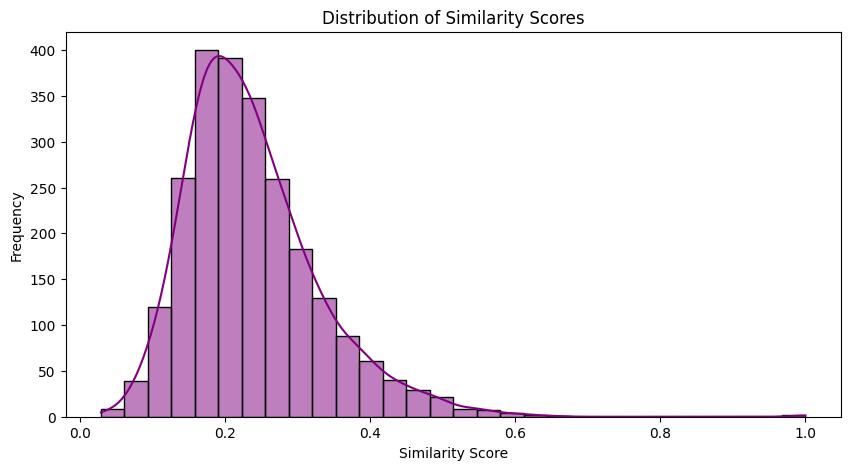

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(similarity_df['hybrid_similarity'], bins=30, kde=True, color='purple')
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()


The above distribution plot helps us to understand the spread of similarity scores that is the distribution of the final hybrid similarity scores (from 0 to 1). So the peak is near 0 meaning most pairs are unrelated.

In [ ]:
# Mark pairs as similar if hybrid score > 0.8 (or your chosen threshold)
similarity_df['is_similar'] = similarity_df['hybrid_similarity'] > 0.8

# Check number of such pairs
print("Number of sentence pairs marked as similar:", similarity_df['is_similar'].sum())


Number of sentence pairs marked as similar: 2
